In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency as chi, probplot

# Data Loading

In [4]:
amazon_data =  pd.read_csv('amz_uk_price_prediction_dataset.csv')
amazon_df = amazon_data.copy()

In [6]:
#Shape of the data
amazon_df.shape

(2443651, 9)

In [8]:
#Null Check
amazon_df.isnull().sum()

uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64

In [10]:
#Check Datatypes
amazon_df.dtypes

uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isBestSeller            bool
boughtInLastMonth      int64
category              object
dtype: object

In [12]:
amazon_df.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [14]:
#Remove Duplicates and check shape again
amazon_df = amazon_df.drop_duplicates(keep='first')
amazon_df.shape

(2443651, 9)

# Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

## Crosstab Analysis:

Create a crosstab between the product category and the isBestSeller status.

Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

## Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

Compute Cramér's V to understand the strength of association between best-seller status and category.
Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


In [16]:
#Check the categories where being best seller is more prevalent
cross_tab = pd.crosstab(amazon_df['category'],amazon_df['isBestSeller'], normalize='index').reset_index()
cross_tab.columns = ['category','non_bestsellers','bestsellers']
cross_tab.sort_values(by='bestsellers', ascending=False)

,category,non_bestsellers,bestsellers
109,Grocery,0.941865,0.058135
254,Smart Home Security & Lighting,0.942308,0.057692
126,Health & Personal Care,0.942314,0.057686
185,Mobile Phone Accessories,0.957529,0.042471
229,Power & Hand Tools,0.964661,0.035339
...,...,...,...
235,Projectors,1.000000,0.000000
231,Printer Accessories,1.000000,0.000000
230,Power Supplies,1.000000,0.000000
14,Basketball Footwear,1.000000,0.000000


In Categories - Groceries, Smart Home Security & Lighting and Health & Personal Care there is about 6% of products which are bestsellers

In [18]:
cross_tab = pd.crosstab(amazon_df['category'],amazon_df['isBestSeller'])

#Perform Chi-Square Test
chi2_stat, p_value, _, _ = chi(cross_tab)

if p_value < 0.05:
    print("There variables category and being a best seller are not independant")
else:
    print("Not enough evidence to prove the relationship")
    


There variables category and being a best seller are not independant


In [19]:
# Compute total sample size
n = cross_tab.values.sum()

# Compute the minimum dimension (rows or columns) minus 1
min_dim = min(cross_tab.shape[0] - 1, cross_tab.shape[1] - 1)

# Calculate Cramér's V
cramers_v = np.sqrt(chi2_stat / (n * min_dim))

#Show the magnitude of the strength of the association
if cramers_v >= 0 and cramers_v < 0.1:
    print("Cramers V : {} : Weak Association".format(cramers_v))
elif cramers_v >= 0.1 and cramers_v < 0.3:
    print("Cramers V : {} : Moderate Association".format(cramers_v))
elif cramers_v >= 0.3 and cramers_v < 0.5:
    print("Cramers V : {} : Strong Association".format(cramers_v))
elif cramers_v >= 0.5:
    print("Cramers V : {} : Very Strong Association".format(cramers_v))
else:
    print("Wrong Values")

Cramers V : 0.1222829439760564 : Moderate Association


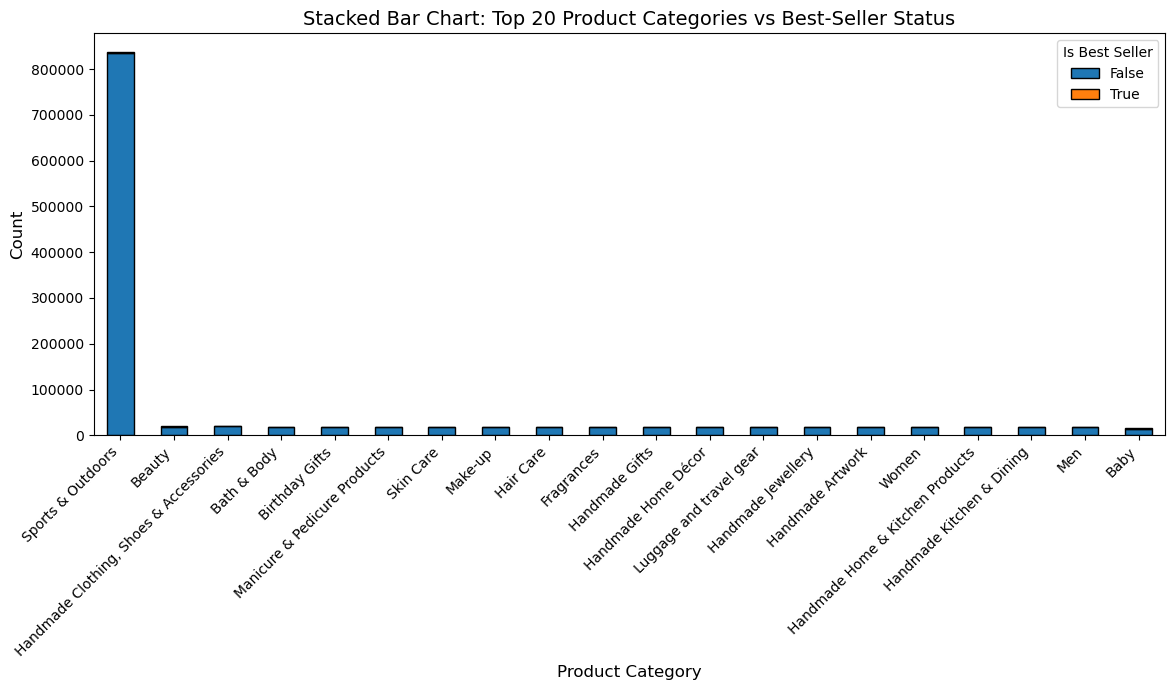

In [20]:
# Get the top 20 categories by total count
top_categories = cross_tab.sum(axis=1).nlargest(20).index

# Filter the contingency table for top 20 categories
cross_tab_top20 = cross_tab.loc[top_categories]

# Plot the stacked bar chart for top 20 categories
cross_tab_top20.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=['#1f77b4', '#ff7f0e'],  # Customize colors
    edgecolor='black'
)

# Add chart labels and title
plt.title('Stacked Bar Chart: Top 20 Product Categories vs Best-Seller Status', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is Best Seller', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.
Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.
Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [26]:
#Removing Outliers 
IQR = amazon_df.price.quantile(q=0.75) - amazon_df.price.quantile(q=0.25)
lower = amazon_df.price.quantile(q=0.25) - 1.5 * IQR
upper = amazon_df.price.quantile(q=0.75) + 1.5 * IQR

#Removing outliers
clean_df = amazon_df[(amazon_df['price'] >= lower) & (amazon_df['price'] <= upper)]

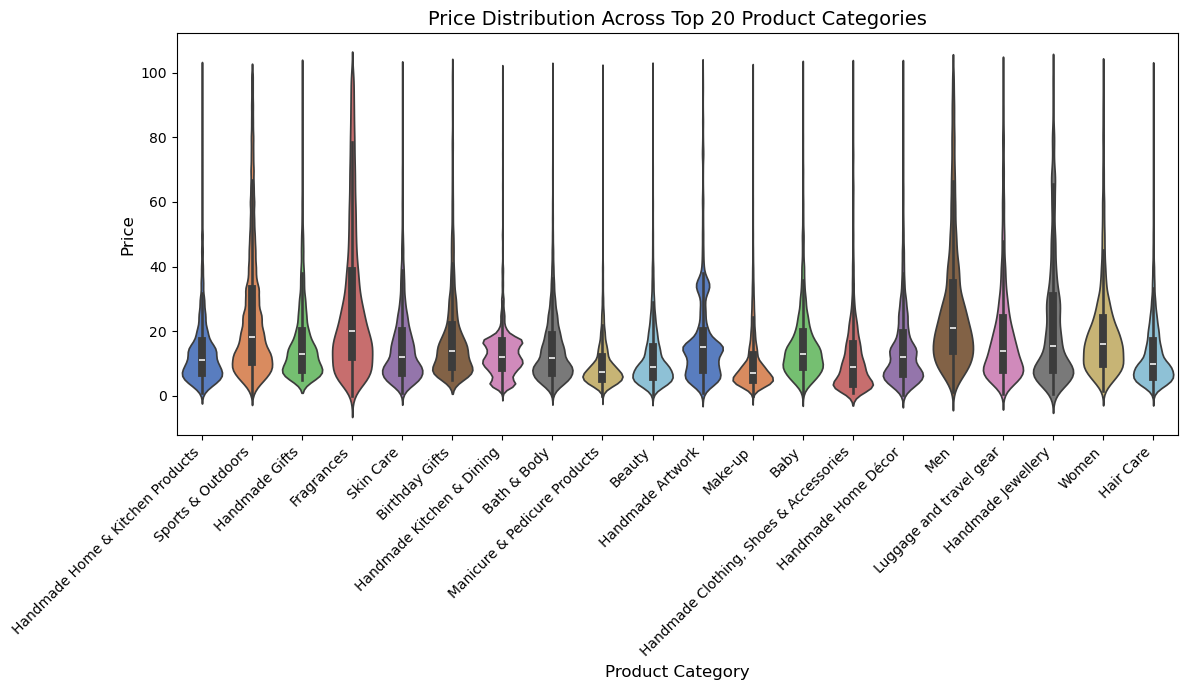

In [28]:
# Get the top 20 categories based on count
top_categories = clean_df['category'].value_counts().nlargest(20).index

# Filter the DataFrame for these top categories
filtered_df = clean_df[clean_df['category'].isin(top_categories)]

# Create a violin plot
plt.figure(figsize=(12, 7))
sns.violinplot(
    data=filtered_df,
    x='category',
    y='price',
    palette='muted',
    hue='category',
    legend=False
)

# Customize plot appearance
plt.title('Price Distribution Across Top 20 Product Categories', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
# Calculate the median price for each category
median_prices = clean_df.groupby('category')['price'].median()

# Find the category with the highest median price
highest_median_category = median_prices.idxmax()
highest_median_price = median_prices.max()

print(f"The category with the highest median price is '{highest_median_category}' with a median price of ${highest_median_price:.2f}.")

The category with the highest median price is 'Desktop PCs' with a median price of $74.00.


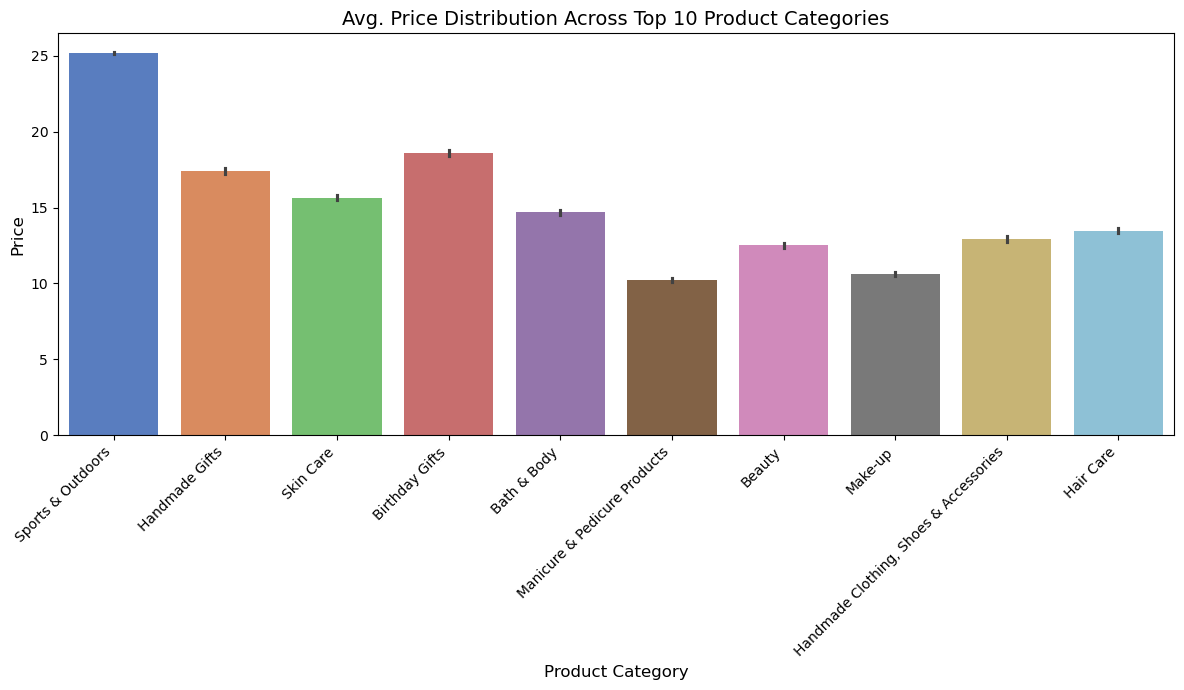

In [31]:
# Get the top 10 categories based on count
top_categories = clean_df['category'].value_counts().nlargest(10).index

# Filter the DataFrame for these top categories
filtered_df = clean_df[clean_df['category'].isin(top_categories)]

# Create a violin plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=filtered_df,
    x='category',
    y='price',
    palette='muted',
    hue='category',
    legend=False,
    estimator='mean'
)

# Customize plot appearance
plt.title('Avg. Price Distribution Across Top 10 Product Categories', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
# Calculate the mean price for each category
mean_prices = clean_df.groupby('category')['price'].mean()

# Find the category with the highest mean price
highest_mean_category = mean_prices.idxmax()
highest_mean_price = mean_prices.max()

print(f"The category with the highest mean price is '{highest_mean_category}' with a median price of ${highest_mean_price:.2f}.")

The category with the highest mean price is 'Motherboards' with a median price of $68.77.


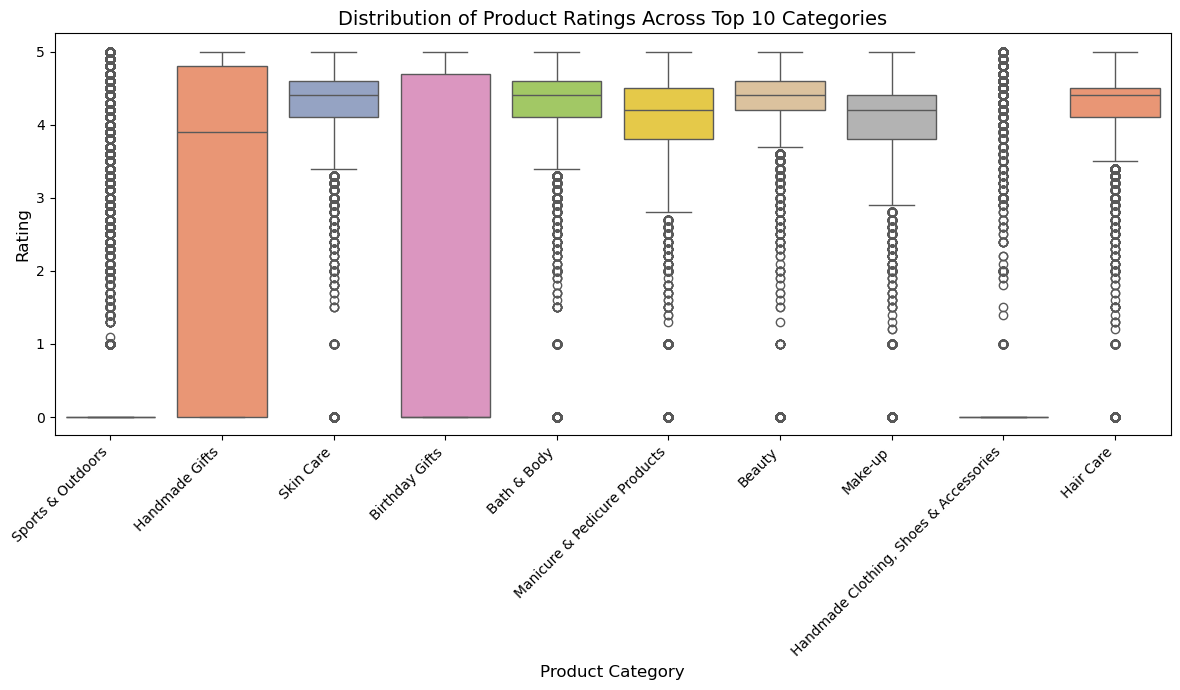

In [33]:
# Get the top 10 categories based on count
top_categories = clean_df['category'].value_counts().nlargest(10).index

# Filter the DataFrame for these top categories
filtered_df = clean_df[clean_df['category'].isin(top_categories)]

# Create a box plot
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=filtered_df,
    x='category',
    y='stars',
    palette='Set2',
    hue = 'category',
    legend=False
)

# Customize plot appearance
plt.title('Distribution of Product Ratings Across Top 10 Categories', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
# Calculate the median rating for each category
median_ratings = clean_df.groupby('category')['stars'].median()

# Find the category with the highest median rating
highest_median_rating_category = median_ratings.idxmax()
highest_median_rating = median_ratings.max()

print(f"The category with the highest median rating is '{highest_median_rating_category}' with a median rating of {highest_median_rating:.2f}.")


The category with the highest median rating is 'Computer Memory' with a median rating of 4.70.


# Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

Calculate the correlation coefficient between price and stars.
Is there a significant correlation between product price and its rating?
Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
Use a correlation heatmap to visualize correlations between all numerical variables.
Examine if product prices typically follow a normal distribution using a QQ plot.

In [36]:
#Calculate the correlation between the price and the stars columns
corr_coeff = clean_df['price'].corr(clean_df['stars'])
print("The correlation coefficient between price & stars : {}".format(corr_coeff))

#Check for each range of correlation coefficients
if (corr_coeff > 0) and (corr_coeff <= 0.5):
    print("Moderate Positive Correlation")
elif (corr_coeff >= 0.5):
    print("Strong Positive Correlation")
elif (corr_coeff >= -0.5) and (corr_coeff < 0):
    print("Moderate Negative Correlation")
elif (corr_coeff < -0.5):
    print("Strong Negative Correlation") 
else:
    print("No Correlation")

The correlation coefficient between price & stars : -0.07767299878181352
Moderate Negative Correlation


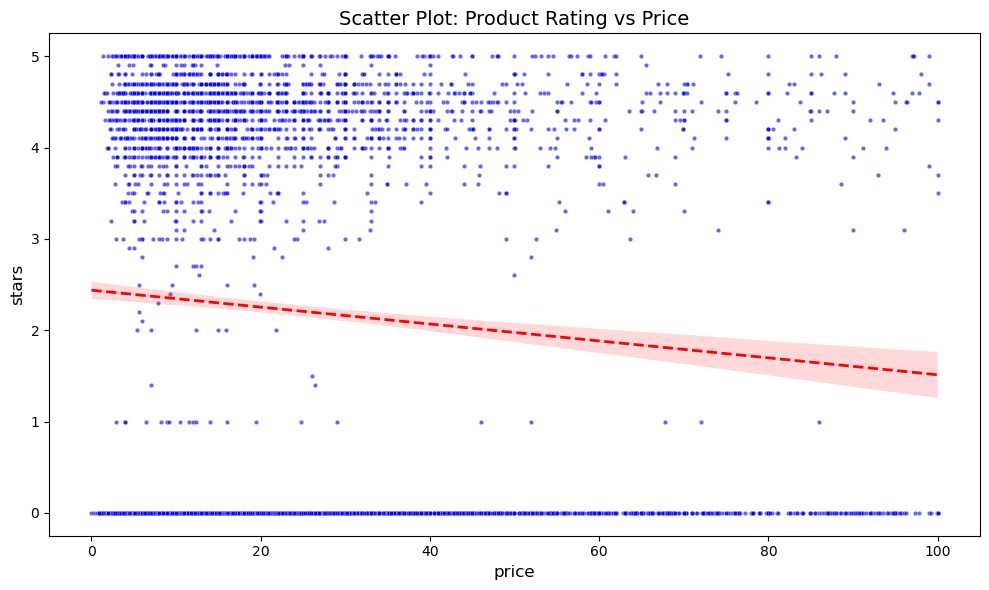

In [37]:
# Downsample the data to a manageable size (e.g., 5000 points)
sampled_data = clean_df.sample(n=5000, random_state=42)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_data, x='price', y='stars', alpha=0.6, s=10, color='b')  # s=10 sets small marker size

# Add titles and labels
plt.title('Scatter Plot: Product Rating vs Price', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Rating', fontsize=12)

# Optional: Add a regression line
sns.regplot(data=sampled_data, x='price', y='stars', scatter=False, color='r', line_kws={"linewidth": 2, 'linestyle': '--'})

# Display the plot
plt.tight_layout()
plt.show()

The negative correlation is visible in the trend line

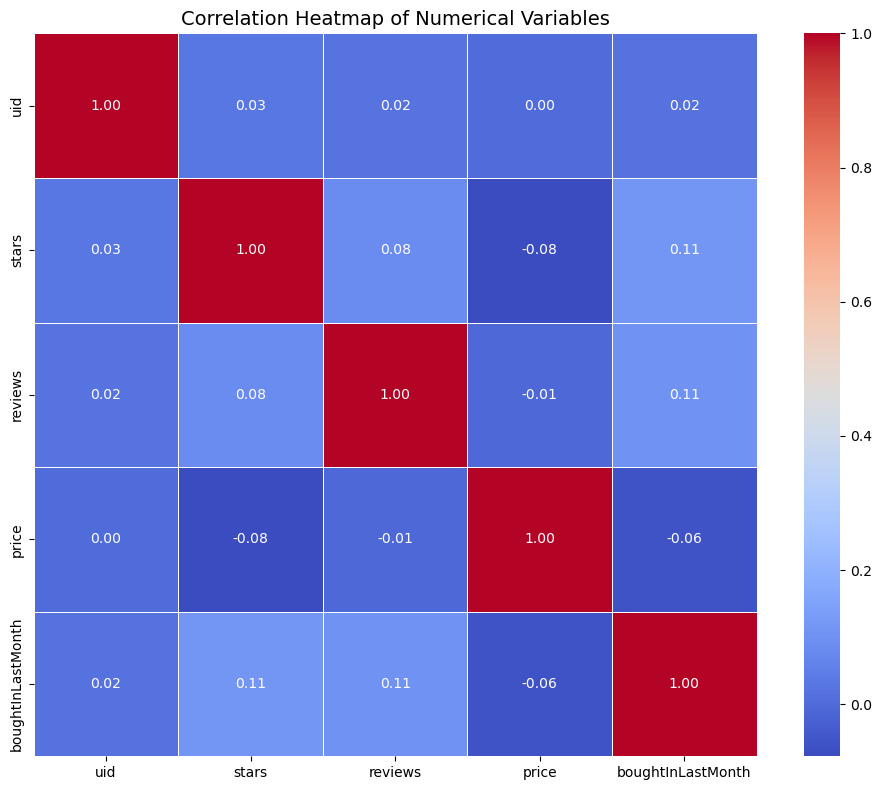

In [39]:
# Select numerical columns
numerical_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix
correlation_matrix = clean_df[numerical_cols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True,
    linewidths=0.5
)

# Customize the plot
plt.title("Correlation Heatmap of Numerical Variables", fontsize=14)
plt.tight_layout()

# Show the heatmap
plt.show()

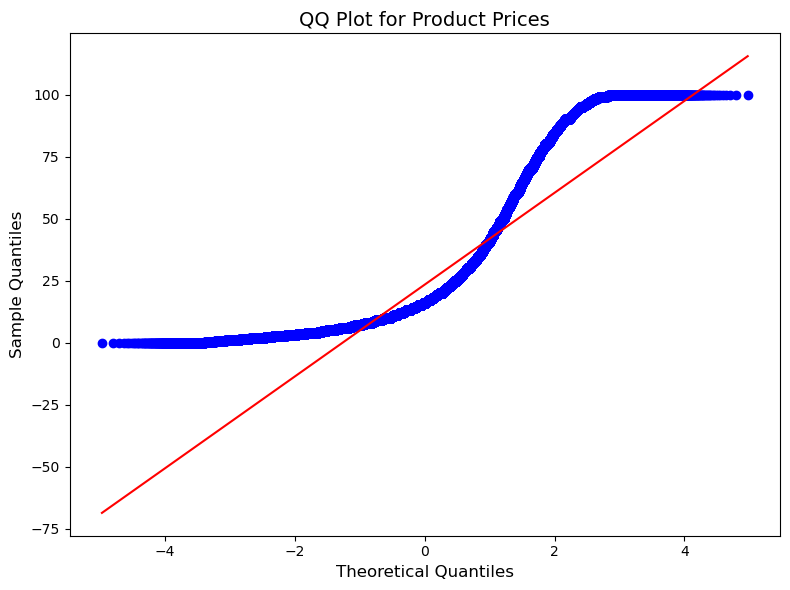

In [40]:
# Create QQ plot
plt.figure(figsize=(8, 6))
probplot(clean_df['price'], dist="norm", plot=plt)

# Customize the plot
plt.title("QQ Plot for Product Prices", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The prices is skewed and doesn't follow a normal distribution